In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import multiprocessing as mp
from itertools import product
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Optional
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Configuration


In [29]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s"
)
logger = logging.getLogger(__name__)

In [30]:
np.random.seed(42)
torch.manual_seed(42)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Processor


In [ ]:
class DataProcessor:
    """
    Data processor designed to fetch and process financial data from
    yahoo financial.

    Attributes:
        tickers (List[str]): List of tickers to download the data from
        start_date (str): Start date of the tickers
        end_date (str): End date of the tickers
        raw_data (dict): Raw data of the financial data
        processed_data (dict): Processed data
    """

    def __init__(
        self,
        tickers: List[str] = ["^MXX", "WALMEX.MX", "BIMBOA.MX"],
        start_date: str = "2010-01-01",
        end_date: str = "2024-01-01",
    ):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.raw_data, self.processed_data = {}, {}

    def fetch_market_data(self) -> Dict[str, pd.DataFrame]:
        """
        Fetches market data for the specified tickers

        Returns:
            Dict[str, pd.DataFrame]: A dictionary containing the raw data for each ticker
        """

        for ticker in tqdm(self.tickers, desc="Fetching data"):
            try:
                data = yf.download(ticker, start=self.start_date, end=self.end_date)

                if data.empty:
                    logger.warning(f"No data found for {ticker}")
                    continue

                if len(data) < 100:
                    logger.warning(
                        f"Limited data for {ticker}: only {len(data)} records"
                    )

                self.raw_data[ticker] = data

            except Exception as e:
                logger.error(f"Error fetching data for {ticker}: {e}")

        return self.raw_data

    def preprocess_data(self, target_column: str = "Close") -> Dict[str, dict]:
        """
        Data preprocessing pipeline with feature engineering and scaling. It applies the following transformations:

        - Log returns
        - Percentage returns
        - Moving averages (20 and 50 days)
        - Bollinger bands (20 days)
        - Min-max scaling
        - Standard scaling
        - Metadata (volatility, skewness, kurtosis)

        Args:
            target_column (str, optional): The column to predict. Defaults to "Close".

        Returns:
            Dict[str, dict]: A dictionary containing the processed data for each ticker
        """
        for ticker, data in self.raw_data.items():
            try:
                log_returns = np.log(
                    data[target_column] / data[target_column].shift(1)
                ).dropna()
                pct_returns = data[target_column].pct_change().dropna()

                ma_20 = data[target_column].rolling(window=20).mean()
                ma_50 = data[target_column].rolling(window=50).mean()
                std_20 = data[target_column].rolling(window=20).std()

                processed = {
                    "raw": data[target_column],
                    "log_returns": log_returns,
                    "pct_returns": pct_returns,
                    "MA_20": ma_20,
                    "MA_50": ma_50,
                    "bollinger_high": ma_20 + 2 * std_20,
                    "bollinger_low": ma_20 - 2 * std_20,
                }

                scaler_minmax = MinMaxScaler()
                scaler_standard = StandardScaler()

                processed["scaled_minmax"] = scaler_minmax.fit_transform(
                    data[target_column].values.reshape(-1, 1)
                )
                processed["scaled_standard"] = scaler_standard.fit_transform(
                    data[target_column].values.reshape(-1, 1)
                )

                processed["metadata"] = {
                    "volatility": log_returns.std(),
                    "skewness": log_returns.skew(),
                    "kurtosis": log_returns.kurtosis(),
                }

                self.processed_data[ticker] = processed

            except Exception as e:
                logger.error(f"Error preprocessing data: {e}")

        return self.processed_data

In [33]:
def prepare_torch_data(
    device: torch.device, X: np.ndarray, y: np.ndarray
) -> DataLoader:
    """
    Prepare DataLoader for training and testing.

    Args:
        X (np.ndarray): Input features
        y (np.ndarray): Target variable

    Returns:
        DataLoader: DataLoader object
    """

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

    train_size = int(0.8 * len(X))
    X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, X_test, y_test

## Visualizer


In [34]:
class FinancialRatiosVisualizer:
    """"""

    def __init__(self, processed_data: pd.DataFrame, raw_data: pd.DataFrame):
        self.processed_data = processed_data
        self.raw_data = raw_data

    def plot_closing_prices(self):
        """
        Visualize the closing prices of the stock
        """

        plt.figure(figsize=(15, 7))
        for ticker, data in self.raw_data.items():
            plt.plot(data.index, data["Close"], label=ticker)

        plt.title("Closing Prices Comparison")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_returns_distribution(self):
        plt.figure(figsize=(15, 7))
        for ticker, data in self.raw_data.items():
            returns = data["Close"].pct_change().dropna()
            sns.histplot(returns, kde=True, label=ticker)

        plt.title("Returns Distribution")
        plt.xlabel("Daily Returns")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_correlation_heatmap(self):
        plt.figure(figsize=(10, 7))
        correlation_matrix = pd.concat(
            [data["Close"] for data in self.raw_data.values()], axis=1
        ).corr()

        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.show()

    def plot_rolling_volatility(self):
        plt.figure(figsize=(15, 7))
        for ticker, data in self.raw_data.items():
            returns = data["Close"].pct_change().dropna()
            rolling_std = returns.rolling(window=20).std()
            plt.plot(data.index, rolling_std, label=ticker)

        plt.title("Rolling Volatility Comparison")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def perform_statistical_test(self):
        print("\nStatistical Tests\n")
        for ticker, data in self.raw_data.items():
            returns = data["Close"].pct_change().dropna()
            adf_result = adfuller(returns)

            print(f"\n{ticker} Augmented Dickey-Fuller Test")
            print(f"ADF Statistic: {adf_result[0]}")
            print(f"p-value: {adf_result[1]}")

            _, p_value = stats.normaltest(returns)
            print(f"Normality Test p-value: {p_value}")

    def visualize_single_stock_preprocessing(self, ticker):
        data = self.raw_data[ticker]
        processed = self.processed_data[ticker]
        target_column = "Close"

        plt.figure(figsize=(20, 10))

        # Original vs Moving Averages
        plt.subplot(2, 2, 1)
        plt.title("Original vs Moving Averages")
        plt.plot(data.index, data[target_column], label="Original")
        plt.plot(data.index, processed["MA_20"], label="20-day MA")
        plt.plot(data.index, processed["MA_50"], label="50-day MA")
        plt.legend()

        # Bollinger Bands
        plt.subplot(2, 2, 2)
        plt.title("Bollinger Bands")
        plt.plot(data.index, data[target_column], label="Price")
        plt.plot(data.index, processed["MA_20"], label="MA 20")
        plt.plot(data.index, processed["bollinger_high"], label="Bollinger High")
        plt.plot(data.index, processed["bollinger_low"], label="Bollinger Low")
        plt.legend()

        # Log Returns Distribution
        plt.subplot(2, 2, 3)
        plt.title("Log Returns Distribution")
        sns.histplot(processed["log_returns"], kde=True)
        plt.xlabel("Log Returns")

        # Returns Scaling Comparison
        plt.subplot(2, 2, 4)
        plt.title("Returns Scaling Comparison")
        plt.plot(data.index, processed["scaled_minmax"], label="MinMax Scaled")
        plt.plot(data.index, processed["scaled_standard"], label="Standard Scaled")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # ACF and PACF for Autocorrelation
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plot_acf(processed["log_returns"], lags=40, ax=plt.gca())
        plt.title("Autocorrelation Function")

        plt.subplot(1, 2, 2)
        plot_pacf(processed["log_returns"], lags=40, ax=plt.gca())
        plt.title("Partial Autocorrelation Function")

        plt.tight_layout()
        plt.show()

    def run_comprehensive_visualization(self):
        self.plot_closing_prices()
        self.plot_returns_distribution()
        self.plot_correlation_heatmap()
        # self.plot_rolling_volatility()

        self.perform_statistical_test()
        for ticker in self.processed_data.keys():
            self.visualize_single_stock_preprocessing(ticker)

## SARIMA


In [35]:
def fit_sarima(args):
    """
    Fit SARIMA model and return AIC

    Args:
        args (tuple): Model parameters and data

    Returns:
        tuple: Model parameters and AIC (or inf if model fails)
    """
    data, p, d, q, P, D, Q, m = args
    try:
        model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, m))
        results = model.fit(disp=False)

        return (p, d, q, P, D, Q), results.aic

    except Exception as e:
        logging.warning(f"Model fitting failed for {(p, d, q, P, D, Q)}: {str(e)}")
        return (p, d, q, P, D, Q), np.inf

In [36]:
def find_best_sarima_order(
    data,
    p_range=(0, 3),
    d_range=(0, 2),
    q_range=(0, 3),
    P_range=(0, 2),
    D_range=(0, 1),
    Q_range=(0, 2),
    m=12,
    n_jobs=None,
):
    """
    Find the best SARIMA order using grid search and AIC criterion with performance optimizations

    Args:
        data (pd.Series): Time series data
        p_range (tuple): Range for AR order
        d_range (tuple): Range for differencing order
        q_range (tuple): Range for MA order
        P_range (tuple): Range for seasonal AR order
        D_range (tuple): Range for seasonal differencing order
        Q_range (tuple): Range for seasonal MA order
        m (int): Seasonal period (e.g., 12 for monthly, 4 for quarterly)
        n_jobs (int, optional): Number of parallel jobs. Defaults to None (uses all CPU cores)

    Returns:
        tuple: Best SARIMA order
    """

    param_combinations = [
        (p, d, q, P, D, Q, m, data)
        for p in range(p_range[0], p_range[1] + 1)
        for d in range(d_range[0], d_range[1] + 1)
        for q in range(q_range[0], q_range[1] + 1)
        for P in range(P_range[0], P_range[1] + 1)
        for D in range(D_range[0], D_range[1] + 1)
        for Q in range(Q_range[0], Q_range[1] + 1)
    ]

    if n_jobs is None:
        n_jobs = mp.cpu_count()

    with mp.Pool(n_jobs) as pool:
        results = list(
            tqdm(
                pool.imap(fit_sarima, param_combinations),
                total=len(param_combinations),
                desc="Searching SARIMA Orders",
            )
        )

    best_params = min(results, key=lambda x: x[1])
    best_order = best_params[0][:3]
    best_seasonal_order = best_params[0][3:] + (m,)

    logging.info(f"Best SARIMA Order: {best_order}")
    logging.info(f"Best Seasonal Order: {best_seasonal_order}")
    logging.info(f"Best AIC: {best_params[1]}")

    return best_order, best_seasonal_order

In [37]:
def sarima_forecast(data, order, seasonal_order, forecast_steps=30):
    """
    Perform SARIMA forecasting

    Args:
        data (pd.Series): Time series data
        order (tuple): SARIMA non-seasonal order (p,d,q)
        seasonal_order (tuple): SARIMA seasonal order (P,D,Q,m)
        forecast_steps (int): Number of steps to forecast

    Returns:
        tuple: Forecast and confidence intervals
    """
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    forecast = results.get_forecast(steps=forecast_steps)
    predicted_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    return results, predicted_mean, confidence_intervals

In [38]:
def evaluate_sarima_model(actual, forecast):
    """
    Evaluate SARIMA model performance

    Args:
        actual (pd.Series): Actual time series values
        forecast (pd.Series): Forecasted values

    Returns:
        dict: Performance metrics
    """
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return {"MSE": mse, "MAE": mae, "MAPE": mape}

## LSTM


In [ ]:
class LSTM(nn.Module):
    def __init__(
        self,
        input_size: int = 1,
        hidden_size: int = 64,
        num_layers: int = 3,
        dropout: float = 0.3,
    ):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the LSTM model with a linear layer

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, input_size)

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, 1)
        """

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

    def train_model(
        self,
        train_loader: DataLoader,
        test_loader: DataLoader,
        num_epochs: Optional[int] = 100,
    ):
        """
        Trains the LSTM model using the training and testing DataLoader

        Args:
            train_loader (DataLoader): DataLoader object for training
            test_loader (DataLoader): DataLoader object for testing
            num_epochs (int, optional): Number of epochs. Defaults to 100.

        Returns:
            LSTM model: Trained LSTM model
        """

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        num_epochs: int = num_epochs

        for epoch in tqdm(range(num_epochs), desc="Training model"):
            outputs = self.train()

            for i, (inputs, labels) in enumerate(train_loader):
                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            if epoch % 10 == 0:
                self.eval()

                with torch.no_grad():
                    test_loss = 0.0
                    for inputs, labels in test_loader:
                        outputs = self(inputs)
                        loss = criterion(outputs, labels)
                        test_loss += loss.item()

                    logger.info(
                        f"Epoch {epoch}/{num_epochs}, Loss: {test_loss / len(test_loader)}"
                    )

        return self

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        Predicts the target variable

        Args:
            X (torch.Tensor): Input features

        Returns:
            torch.Tensor: Predicted target variable
        """

        self.eval()
        with torch.no_grad():
            y_pred = self(X)

        return y_pred

    def plot_training_metrics(self, train_loss: List[float], test_loss: List[float]):
        """
        Plot training and testing loss

        Args:
            train_loss (List[float]): Training loss
            test_loss (List[float]): Testing loss
        """

        plt.figure(figsize=(10, 5))
        plt.plot(train_loss, label="Train Loss")
        plt.plot(test_loss, label="Test Loss")
        plt.title("Training and Testing Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

## Comparing both models


In [40]:
def compare_forecasting_models(
    data: pd.Series, train_size: float = 0.8, forecast_horizon: int = 30
) -> Dict[str, float]:
    """
    Compare SARIMA and LSTM forecasting models

    Args:
        data (pd.Series): Time series data
        train_size (float): Training size
        forecast_horizon (int): Number of steps to forecast

    Returns:
        dict: Performance metrics for both models
    """

    train_size_index = int(len(data) * train_size)
    train_data = data[:train_size_index]
    test_data = data[train_size_index:]

    best_order, best_seasonal_order = find_best_sarima_order(train_data)
    sarima_results, sarima_forecast_mean, sarima_ci = sarima_forecast(
        data, best_order, best_seasonal_order, forecast_steps=forecast_horizon
    )

    sarima_metrics = evaluate_sarima_model(
        test_data, sarima_forecast_mean[: len(test_data)]
    )

    lstm_metrics = {"MSE": 0, "MAE": 0, "MAPE": 0}

    plt.figure(figsize=(15, 10))
    plt.plot(data.index, data, label="Actual Data", color="green")
    forecast_index = pd.date_range(
        start=data.index[-1],
        periods=forecast_horizon + 1,
        freq=data.index.freq,
    )[1:]

    plt.plot(forecast_index, sarima_forecast_mean, label="SARIMA Forecast", color="red")
    plt.fill_between(
        forecast_index,
        sarima_ci.iloc[:, 0],
        sarima_ci.iloc[:, 1],
        color="pink",
        alpha=0.3,
        label="95% Confidence Interval",
    )

    plt.title("Time Series Forecast Comparison")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "SARIMA": {
            "order": best_order,
            "seasonal_order": best_seasonal_order,
            "metrics": sarima_metrics,
            "forecast": sarima_forecast_mean,
        },
        "LSTM": lstm_metrics,
    }

## Main Execution


In [41]:
data_processor = DataProcessor()
raw_data = data_processor.fetch_market_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Fetching data: 100%|██████████| 3/3 [00:00<00:00, 22.38it/s]


In [42]:
processed_data = data_processor.preprocess_data()

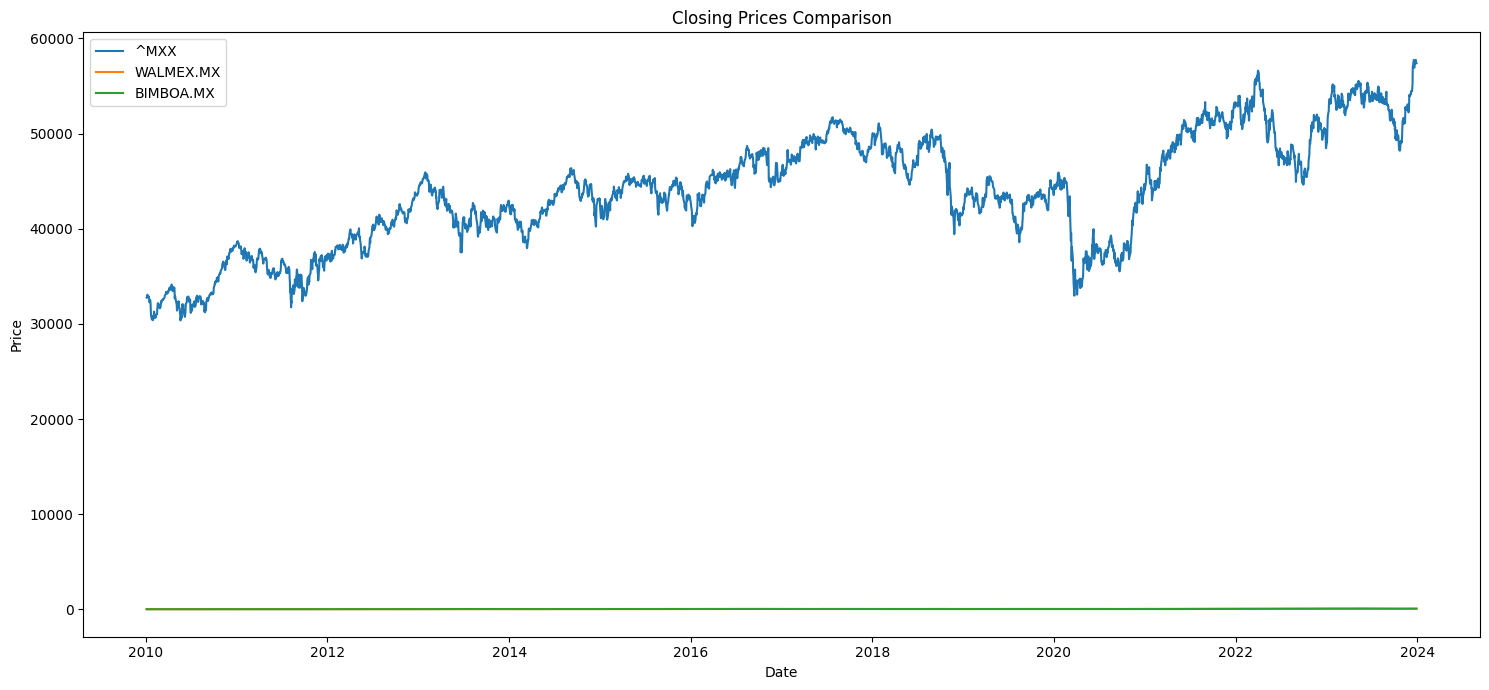

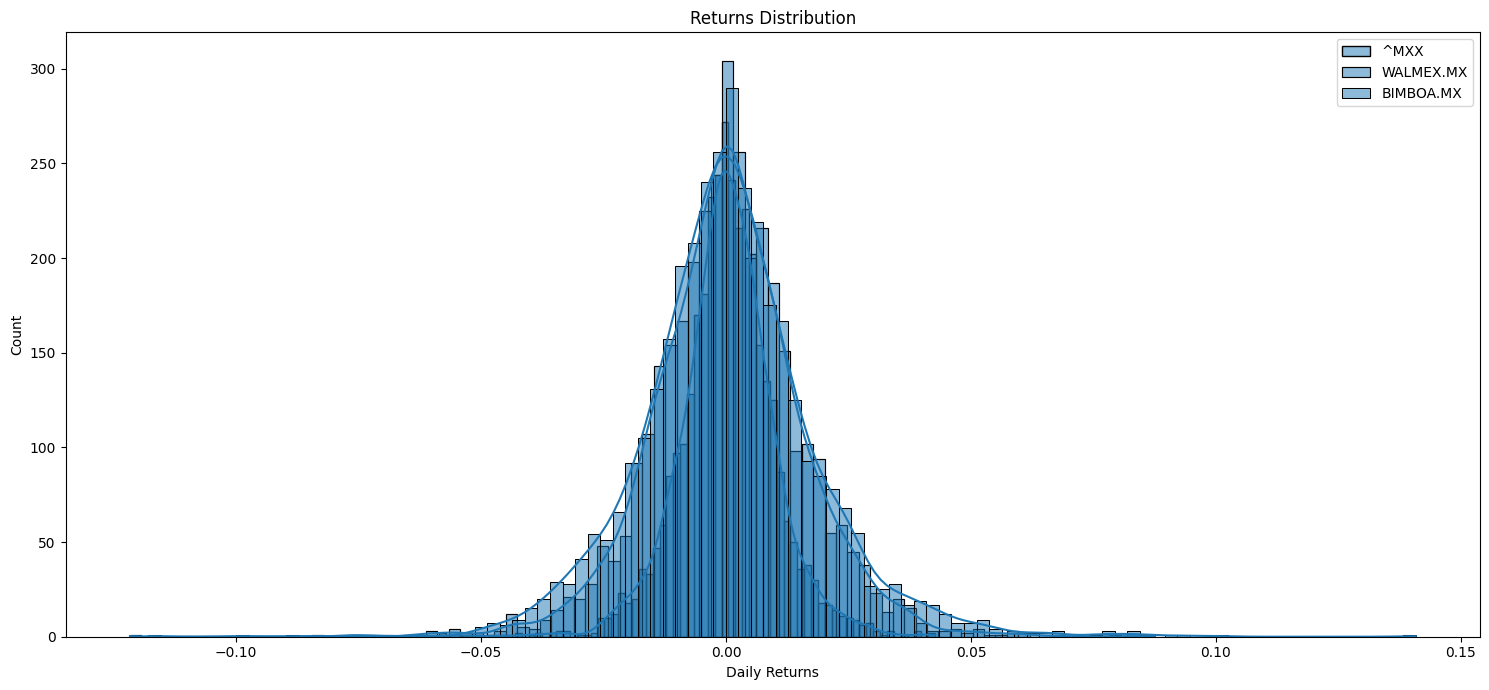

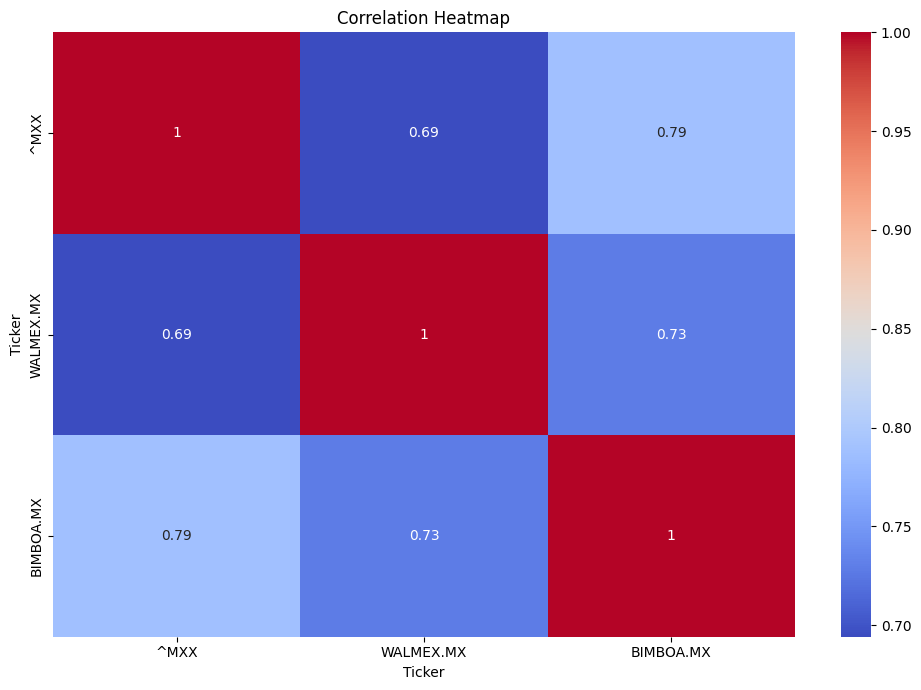


Statistical Tests


^MXX Augmented Dickey-Fuller Test
ADF Statistic: -35.95678228896737
p-value: 0.0
Normality Test p-value: [2.389293e-68]

WALMEX.MX Augmented Dickey-Fuller Test
ADF Statistic: -18.78533246091337
p-value: 2.0238874613719383e-30
Normality Test p-value: [1.26138343e-56]

BIMBOA.MX Augmented Dickey-Fuller Test
ADF Statistic: -39.68159445427102
p-value: 0.0
Normality Test p-value: [1.72494633e-86]


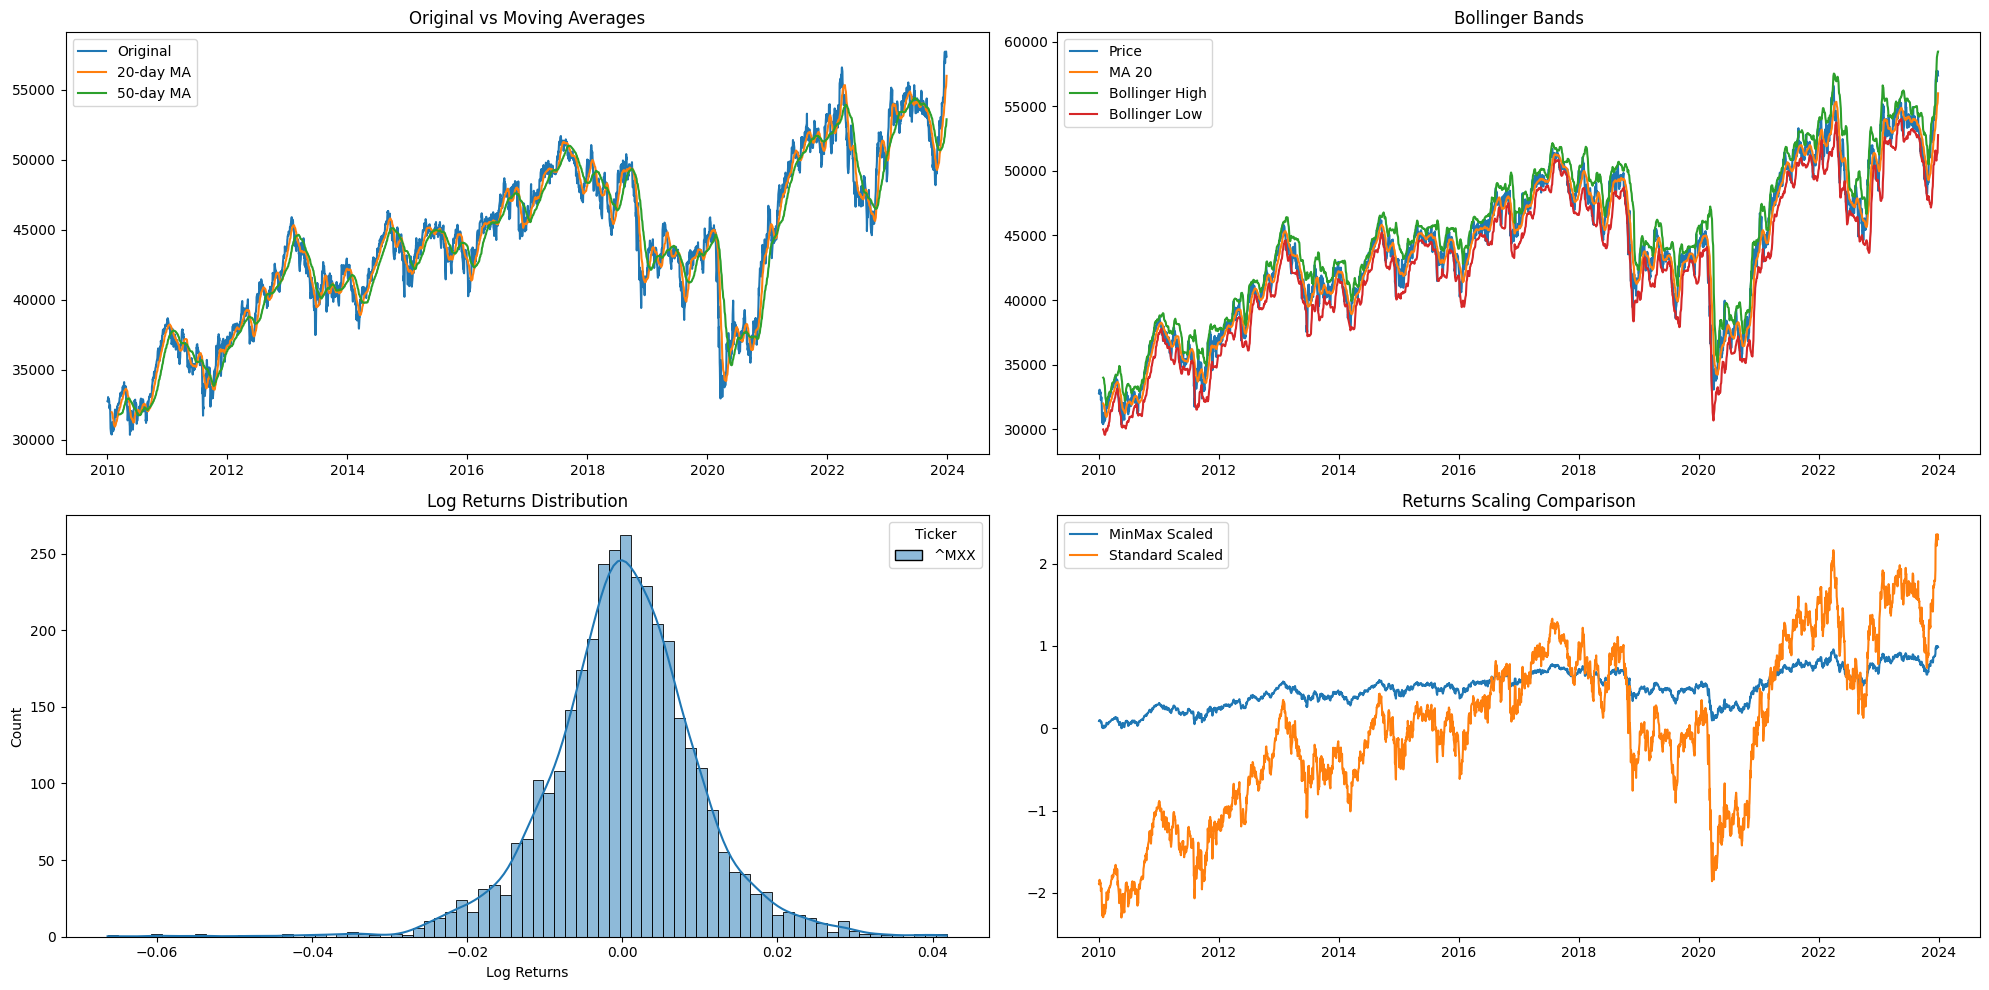

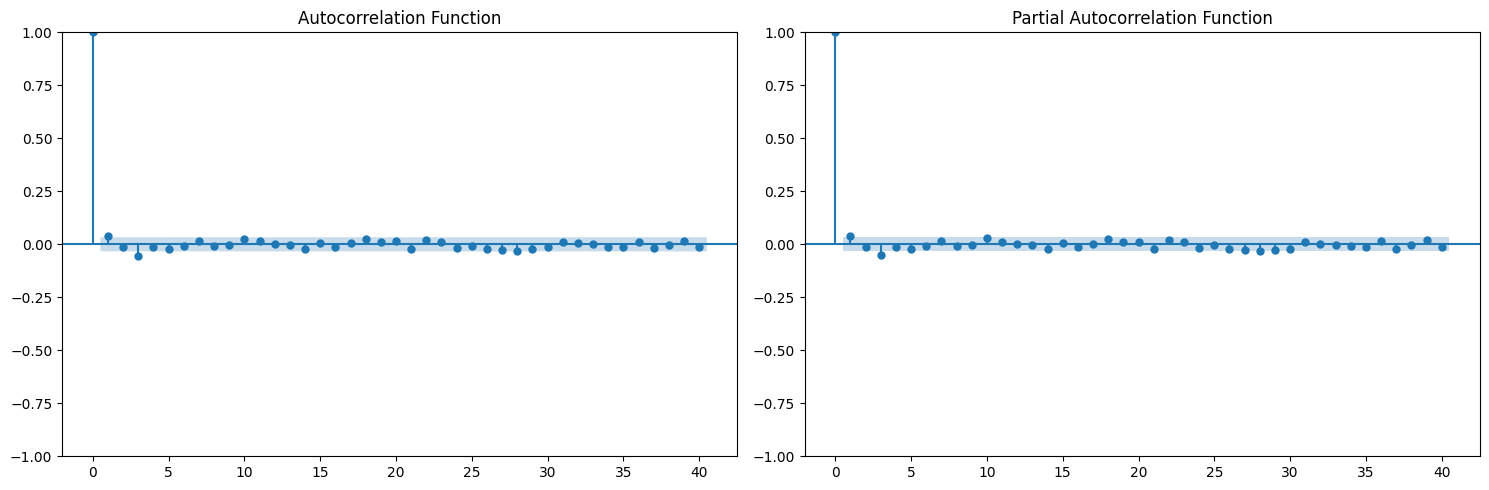

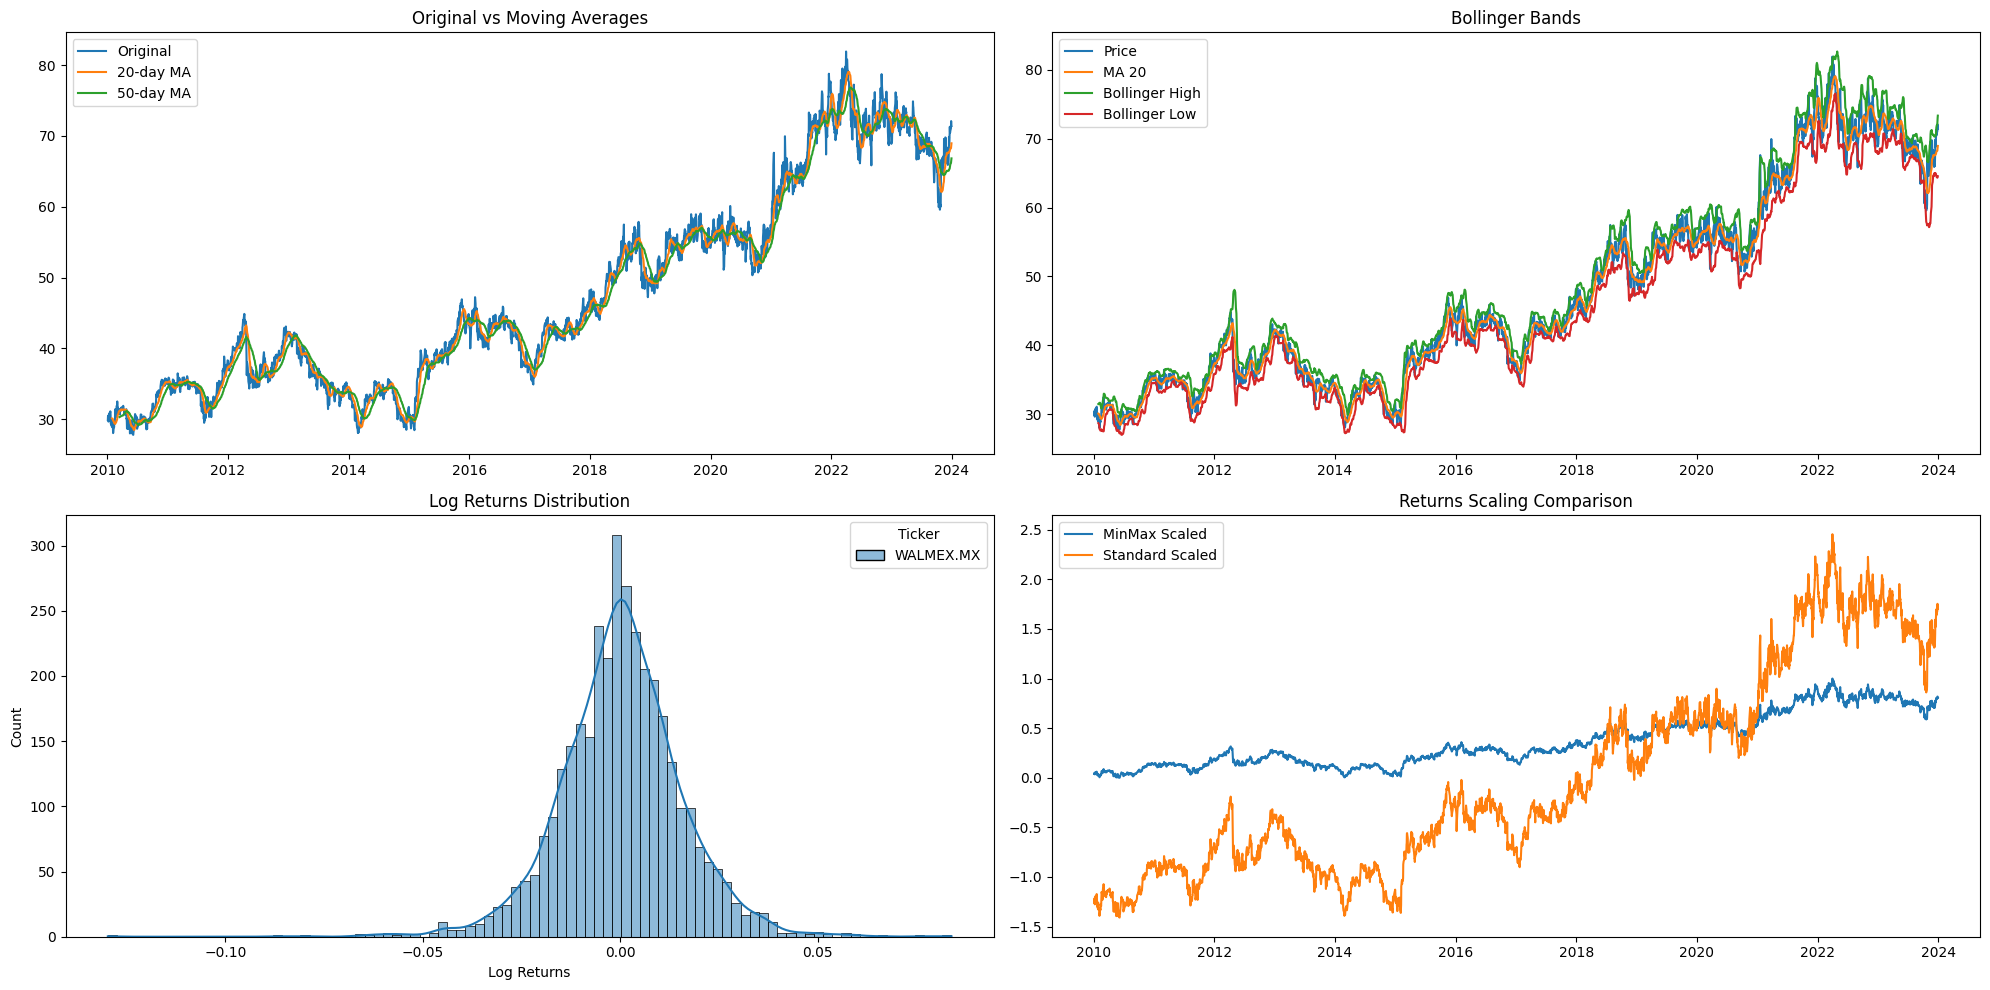

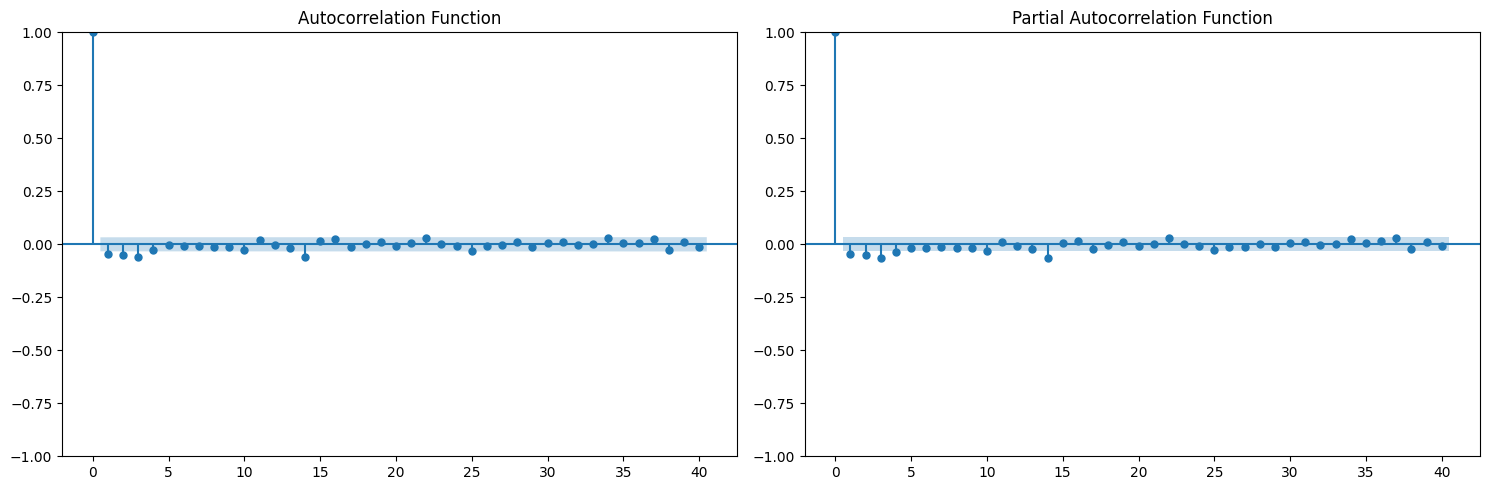

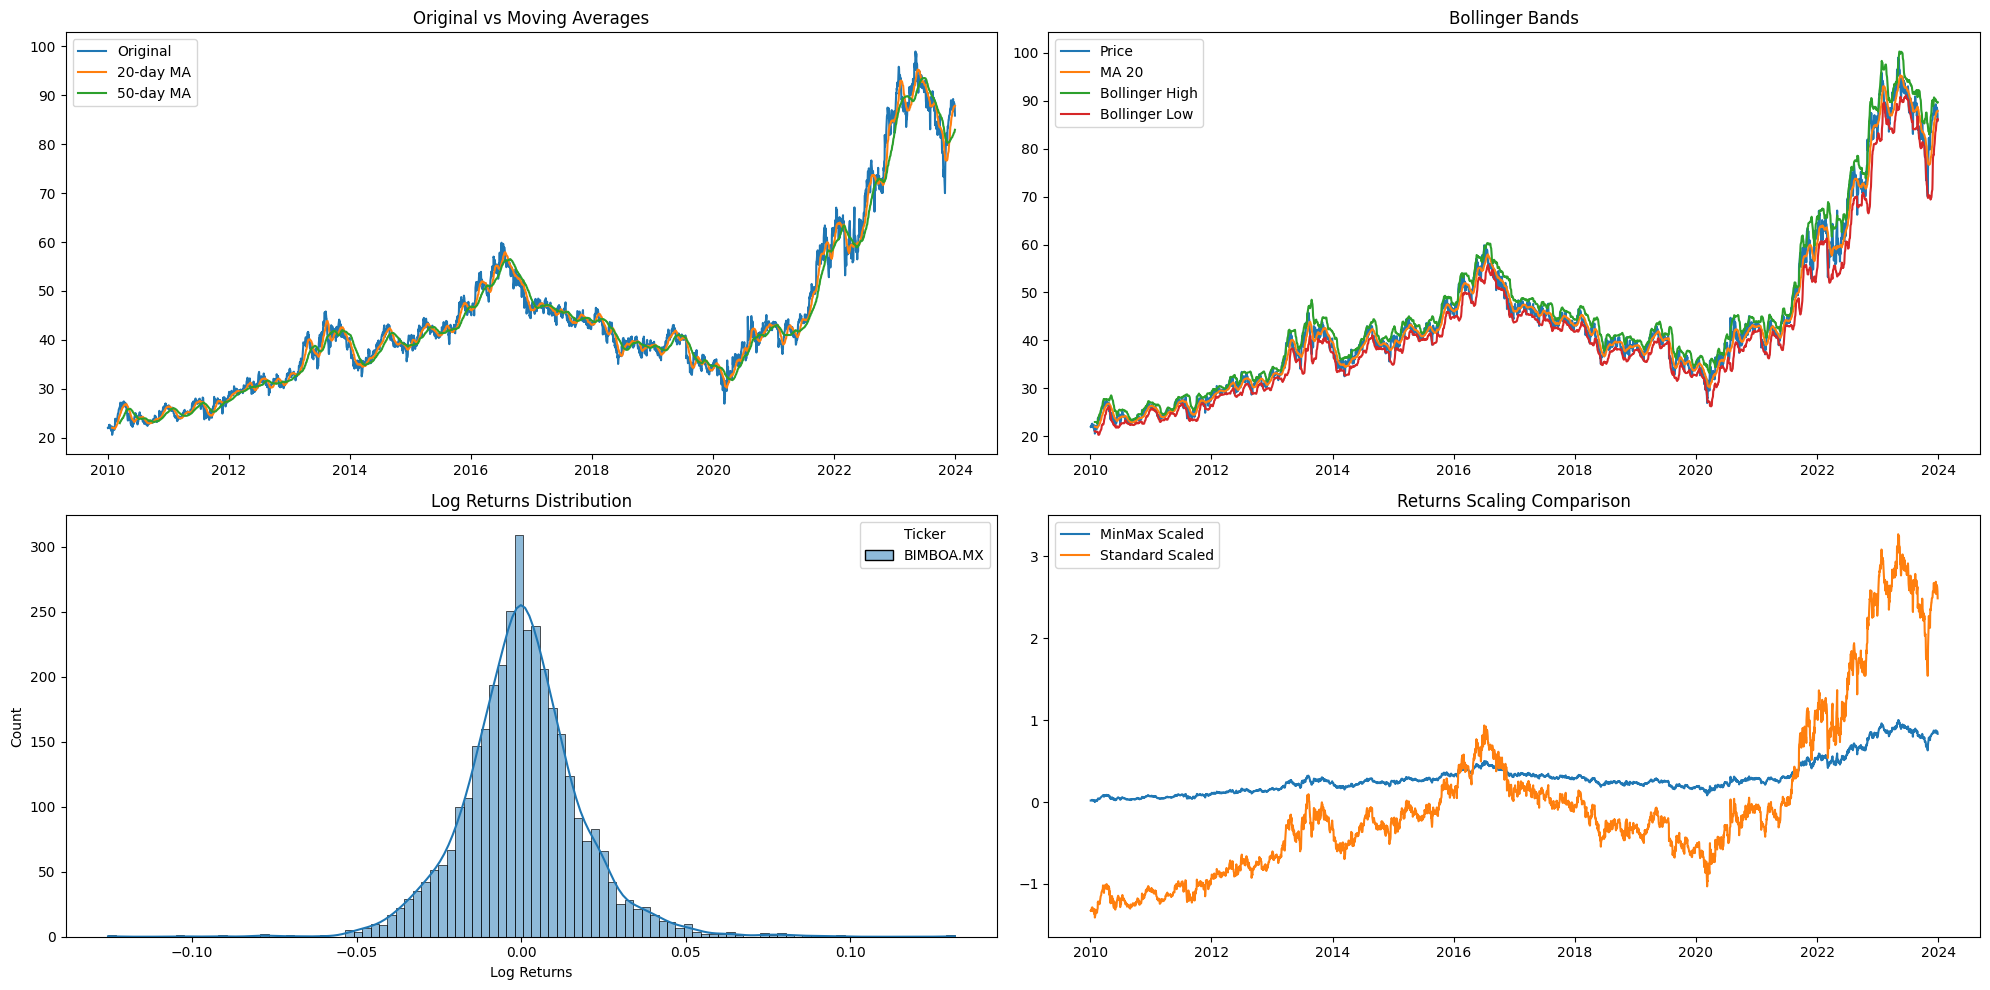

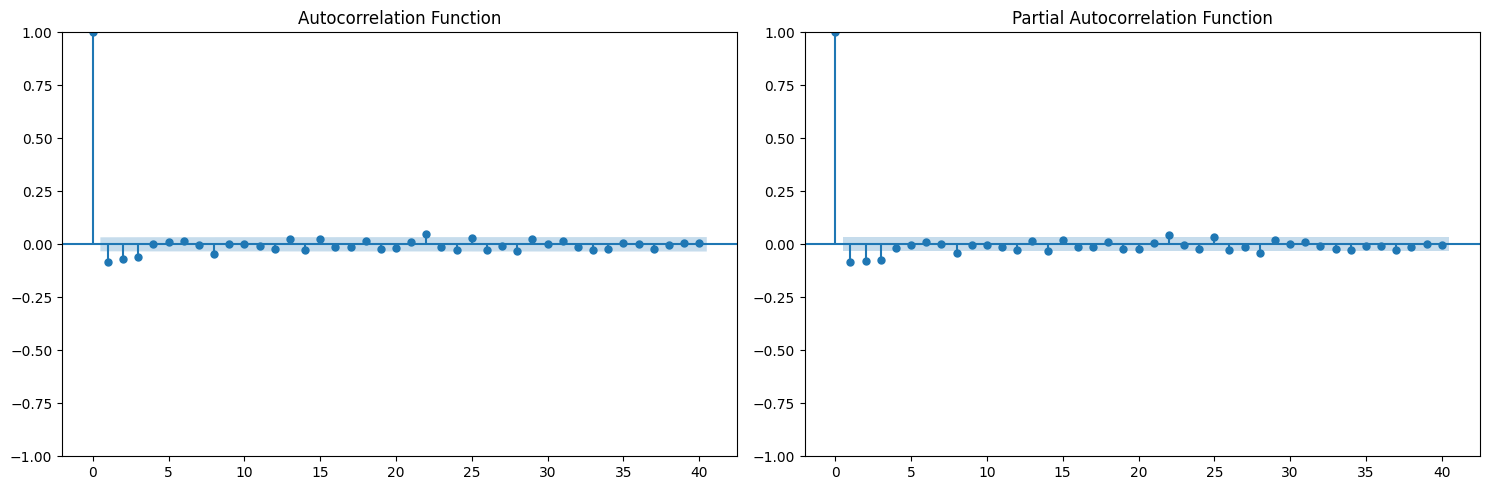

In [43]:
visualizer = FinancialRatiosVisualizer(processed_data, raw_data)
visualizer.run_comprehensive_visualization()

In [44]:
first_ticker = list(processed_data.keys())[0]
data = processed_data[first_ticker]["raw"]

In [45]:
def create_sequences(data, seq_length: int = 30):
    X, y = [], []

    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])

    return np.array(X), np.array(y)

In [46]:
sequence_length = 30
X, y = create_sequences(data.values, sequence_length)

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1))

In [48]:
train_loader, test_loader, X_test, y_test = prepare_torch_data(
    device, X_scaled, y_scaled
)

In [49]:
model = LSTM().to(device)
model.train_model(train_loader, test_loader)

Training model: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


LSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [50]:
predictions = model.predict(X_test).cpu().numpy()
mse = mean_squared_error(y_test.cpu().numpy(), predictions)
mae = mean_absolute_error(y_test.cpu().numpy(), predictions)

In [51]:
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")

MSE: 0.08, MAE: 0.23
RMSE: 0.29


In [ ]:
comparison_results = compare_forecasting_models(data)

Searching SARIMA Orders:   0%|          | 0/864 [00:00<?, ?it/s]2024-12-02 19:43:13,062 - WARNING: Model fitting failed for (0, 0, 0, 0, 0, 12): The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
2024-12-02 19:43:13,063 - WARNING: Model fitting failed for (0, 0, 0, 1, 2, 12): The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
2024-12-02 19:43:13,066 - WARNING: Model fitting failed for (0, 0, 1, 0, 0, 12): The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
2024-12-02 19:43:13,065 - WARNING: Model fitting failed for (0, 0, 0, 1, 0, 12): The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
2024-12-02 19:43:13,063 - WARNING: Model fitting failed for (0, 0, 0, 0, 2, 12): The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
2024-12-02 19:43:13,064 - WARNING: Model 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16702D+01    |proj g|=  3.00377D-02


 This problem is unconstrained.


In [ ]:
print(f"SARIMA Order: {comparison_results['SARIMA']['order']}")
print(f"SARIMA Seasonal Order: {comparison_results['SARIMA']['seasonal_order']}")
print(f"SARIMA Metrics: {comparison_results['SARIMA']['metrics']}")